# Emotion Recognition from Facial Expressions

Group 40: Alvaro Menéndez Ros, Juan José Leguineche Gallego, Pablo Herrero Ortiz

## 1. Introduction

This project implements an **Emotion Recognition system** using facial image data to classify human emotions based on visual expressions. The system is designed to detect and interpret emotions such as happiness, sadness, anger, surprise, fear, disgust, and neutrality. The solution follows a complete machine learning pipeline, integrating computer vision and classification techniques to operate on image data from both static datasets and live camera input.

1. **Data acquisition and preparation**: Facial expression data is obtained from the FER2013 dataset, which contains grayscale images labeled with emotion categories. The data is explored, reshaped, and preprocessed to handle class imbalance and prepare it for feature extraction and model training.
2. **Feature engineering**: Meaningful visual features are extracted from the images, exploring different strategies to achieve robust and efficient representations.
3. **Learning methods**: The machine learning models trained and evaluated are Support Vector Machines (SVM), Multi-Layer Perceptrons (MLP), Random Forests and Fuzzy Systems.
4. **Model comparison and analysis**: All approaches are compared, identifying optimal models and features. The best-performing model is deployed in a real-time demo (in an additional python file) that captures video from a laptop camera, detects faces and classifies the displayed emotion.

The notebook is structured to reflect this workflow step by step. While it is divided into more detailed sections, they all contribute to the four stages defined above.  

### 1.1. Imports

To run this notebook, several libraries are needed. The code cell below gathers all required imports. 

**Required Installations:** Python (3.13.5), numpy (2.2.6), pandas (2.3.2), matplotlib (3.10.6), opencv-python (4.12.10)...

*Note: Versions in previous list are those used for the execution. While older versions may still work, compatibility cannot be fully guaranteed.*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 2. Data Acquisition and Visualization

This section focuses on obtaining the raw dataset and performing initial visualizations to guide the preprocessing stage.

As mentioned previously, the project uses the FER2013 dataset, which contains grayscale images of facial expressions labeled within seven emotion categories: angry, disgust, fear, happy, sad, surprise, and neutral. The dataset is available as a single .csv file from Kaggle, where each image is represented as a sequence of pixel intensity values alongside its corresponding emotion label.

The dataset contains predefined training, public test, and private test splits, which are preserved for consistent evaluation. After loading, several visualizations are generated to gain an initial understanding of the data distribution and quality. These analyses support informed decisions for preprocessing steps.

In the following cell, the data path (constant) is defined and the dataframe obtained. After, there is also a short visualization of the first five rows to illustrate the format.

In [62]:
DATA_PATH = "data/fer2013.csv"

if not os.path.exists(DATA_PATH):
    print("Dataset not found. Please download 'fer2013.csv' from Kaggle and place it in this directory.")

df = pd.read_csv(DATA_PATH)

In [63]:
print("Dataset shape (rows, cols):", df.shape)
df.head()

Dataset shape (rows, cols): (35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### 2.1. Usage and emotion distribution

The columns of the dataset can be described as follows:
- emotion: Integer label from 0 to 6 for the seven emotion classes.
- pixels: string of 2304 (48x48) space separated pixel values of the image.
- Usage: Indicates with a string whether the sample belongs to the Training, PublicTest, or PrivateTest split

The usage split, as mentioned, should be 80% for training data, 10% for public test (validation) and 10% for private test. This distribution is now checked with a plot.

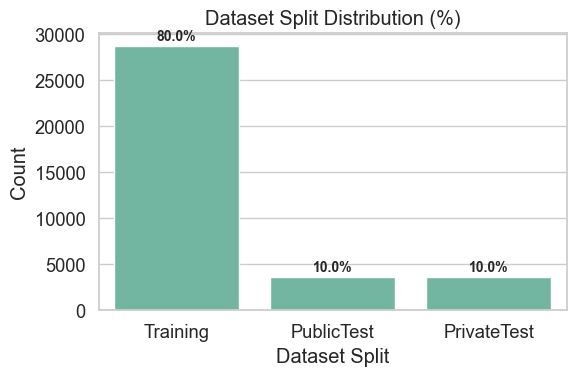

In [64]:
split_counts = df['Usage'].value_counts()
split_perc = 100 * split_counts / split_counts.sum()

split_df = pd.DataFrame({'Count': split_counts, 'Percentage': split_perc})

plt.figure(figsize=(6,4))
ax = sns.barplot(x=split_df.index, y='Count', data=split_df)

for i, (count, perc) in enumerate(zip(split_df['Count'], split_df['Percentage'])):
    ax.text(i, count + max(split_df['Count']) * 0.01, f'{perc:.1f}%', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Dataset Split Distribution (%)")
plt.xlabel("Dataset Split")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Now, the code provided in the assignment to split the dataset and store it in different csv files is executed. All plotting done onwards will be done with only train data to avoid data leakage.

In [65]:
trai_df = df[df['Usage']== 'Training'].copy()
vali_df = df[df['Usage'] == 'PublicTest'].copy()
test_df = df[df['Usage'] == 'PrivateTest'].copy() 

trai_df.to_csv("./data/fer2013_train.csv", encoding='utf-8', index=False)
vali_df.to_csv("./data/fer2013_validation.csv", encoding='utf-8', index=False)
test_df.to_csv("./data/fer2013_test.csv", encoding='utf-8', index=False)

It can be assumed that images across all dataset partitions (training, public test, and private test) do not present significant visual differences. Therefore, plotting sample images by Usage label was considered unnecessary.

Regarding emotions, the distribution is reportedly unequal amongst classes. Therefore, after an emotion mapping based on dataset information, the count of images per emotion will be plotted to illustrate the differences. Later, some sample images will be reconstructed using NumPy arrays for each emotion.

In [66]:
emotion_labels = {
    0:'0: Angry',
    1:'1: Disgust',
    2:'2: Fear',
    3:'3: Happy',
    4:'4: Sad',
    5:'5: Surprise',
    6:'6: Neutral'
}

<Figure size 800x500 with 0 Axes>

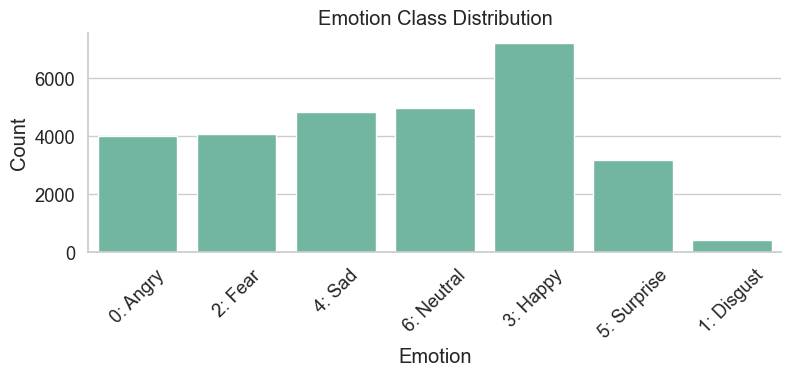

In [67]:
plt.figure(figsize=(8,5))
sns.catplot(data=trai_df.replace({'emotion': emotion_labels}), kind='count', x='emotion', height=4, aspect=2)
plt.title("Emotion Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

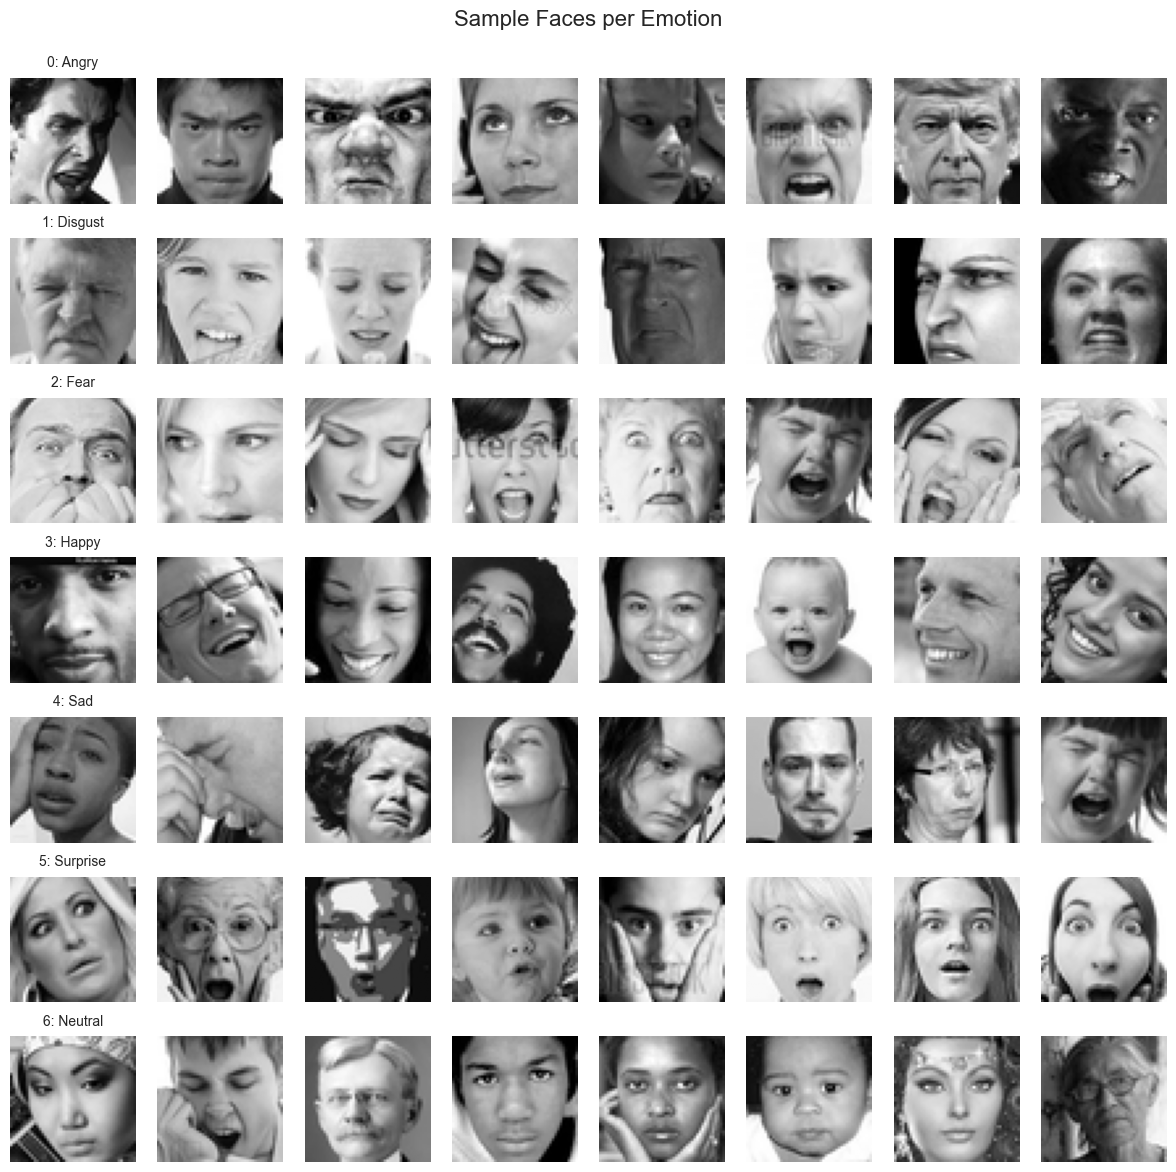

In [68]:
fig, axes = plt.subplots(7, 8, figsize=(12, 12))
fig.suptitle("Sample Faces per Emotion", fontsize=16)

for i, (emotion, group) in enumerate(trai_df.groupby('emotion')):
    samples = group.sample(8, random_state=42)
    for j, pixels in enumerate(samples['pixels']):
        img = np.array(pixels.split(), dtype='uint8').reshape(48, 48)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(emotion_labels[emotion], fontsize=10, pad=8)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

In some cases, differences between classes are clear to the human eye, although that is not always true. Most expressions contain samples that can appear very similar (*"Disgust"* and *"Angry"*, *"Surprise"* and *"Fear"*), especially given the low resolution and grayscale format. As even humans may disagree on certain labels, misclassifications with machine learning models are expected.

This visual overlap means that low accuracies will be the norm, having difficulties to categorize the majority of them correctly. To improve the performance as much as possible, it is important to define robust feature extraction and data preprocessing steps, which help better separate classes in the feature space.

### 2.2. Brightness distribution

The following plots explore the distribution of average pixel brightness across the dataset and per emotion.
They help identify whether lighting or exposure differences could bias emotion classification.

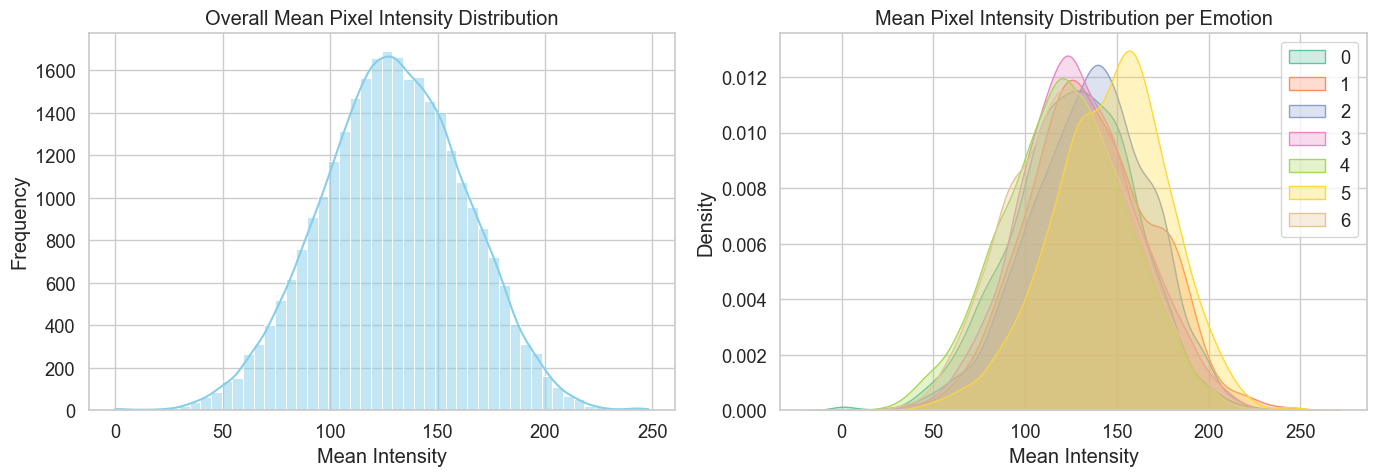

In [69]:
means = trai_df['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=int).mean())

fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(means, kde=True, bins=50, color='skyblue', ax=axes[0])
axes[0].set_title("Overall Mean Pixel Intensity Distribution")
axes[0].set_xlabel("Mean Intensity")
axes[0].set_ylabel("Frequency")

for emotion, group in trai_df.groupby('emotion'):
    # Instead of plotting overall frequencies, use density as classes have different sizes
    subset_means = group['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=int).mean())
    sns.kdeplot(subset_means, label=emotion, fill=True, alpha=0.3, ax=axes[1])

axes[1].set_title("Mean Pixel Intensity Distribution per Emotion")
axes[1].set_xlabel("Mean Intensity")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.show()

The overall distribution is roughly normal, centered around mid-gray (120-130) values, which indicates balanced brightness. Knowing this, a simple global normalization (such as scaling the pixel values) should be sufficient to handle illumination.

Regarding emotions, all of them show overlapping intensity profiles, meaning brightness alone does not discriminate enough. This, which could be partially appreciated visually in the previous images, indicates that feature extraction must focus in capturing more complex facial patterns.

### 2.3. Average face and pixel variance per emotion

The first plot of this section shows the average face computed for each emotion by taking the mean pixel intensities across multiple samples. It can provide a quick overview of how facial structures differ (or overlap) between emotions and highlights the visual patterns.

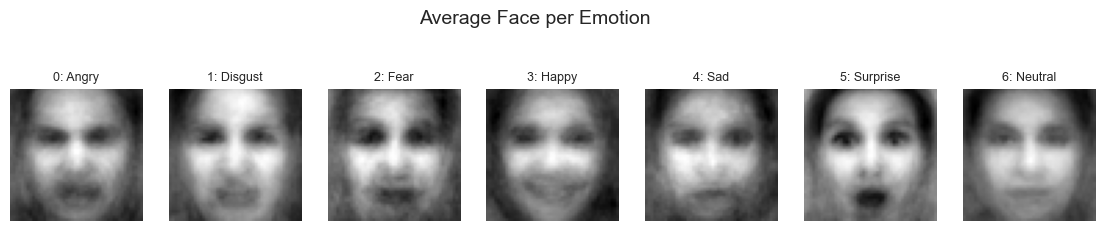

In [70]:
avg_faces = {}
for emotion, group in trai_df.groupby('emotion'):
    imgs = np.stack(group['pixels'].sample(200, random_state=42).apply(lambda x: np.fromstring(x, sep=' ', dtype=int)))
    avg_faces[emotion_labels[emotion]] = imgs.mean(axis=0).reshape(48, 48)

fig, axes = plt.subplots(1, 7, figsize=(14, 3))
for i, (emotion, img) in enumerate(avg_faces.items()):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(emotion, fontsize=9)
    axes[i].axis('off')
plt.suptitle("Average Face per Emotion", fontsize=14)
plt.show()


It can be seen that some subtle distinctions appear, such as open mouths and eyes for *"Surprise"* and *"Fear"* or curved mouths for *"Happy"*. However, most other facial features appear visually similar, and the limited resolution makes detailed comparisons difficult.

Overall, the overlap confirms that, in many emotions, facial differences are very subtle, proving the challenging nature of classification.

As the last visualization, a boxplot to analyze the variance of pixel intensities per emotion has been created. It helps identify whether certain emotions contain noisier or more homogeneous samples.

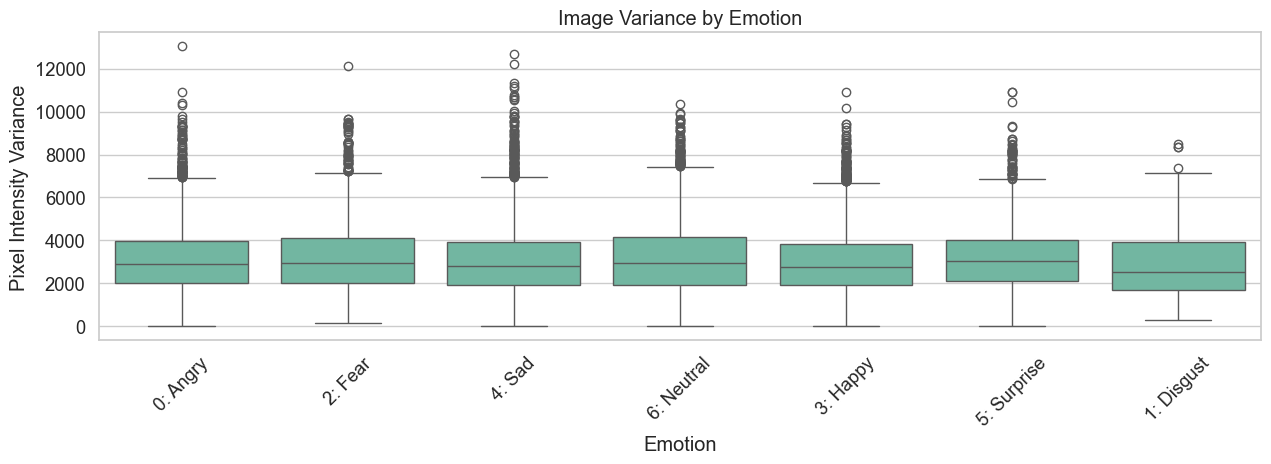

In [71]:
variances = trai_df.assign(variance=trai_df['pixels'].apply(lambda x: np.var(np.fromstring(x, sep=' ', dtype=int))))
plt.figure(figsize=(15,4))
sns.boxplot(x='emotion', y='variance', data=variances.replace({'emotion': emotion_labels}))
plt.title("Image Variance by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Pixel Intensity Variance")
plt.xticks(rotation=45)
plt.show()

Median variances are similar across all emotions, further indicating the comparable contrast levels and lighting conditions across the dataset.

However, there is an abundance of high-variance outliers, which indicates inconsistent image quality. This is possibly due to differences in face positioning, illumination, or expression intensity.
It reinforces the need for preprocessing steps like normalization or augmentation to mitigate variability and improve robustness.

## 3. Preprocessing